# Reverse-engineer toy checkpoints

The purpose of this notebook is to reverse engineer the two weird toy models we found and their corresponding phase transitions.

**Loss curves** 
1. morning-donkey-180: https://wandb.ai/perceptual-alignment/induction_test/runs/0diekj2x?workspace=user-praneetquantumx
2. silver-jazz-185: https://wandb.ai/perceptual-alignment/induction_test/runs/g5tfugyy?workspace=user-praneetquantumx 

Things to do:
1. Plot weight norms
2. Line up weight norms with loss

I'll also replicate the results with the corrected loss function and adding noise to the background.

In [1]:
from dataclasses import dataclass
from vit_prisma.models.layers.transformer_block import TransformerBlock
import torch.nn as nn
import torch
import pandas as pd

import wandb

from huggingface_hub import hf_hub_download
import torch
from vit_prisma.models.base_vit import BaseViT
from vit_prisma.configs.DSpritesConfig import GlobalConfig
from vit_prisma.utils.wandb_utils import update_dataclass_from_dict
from ImagenetConfig import GlobalConfig

from huggingface_hub import HfApi

import csv
import os



In [2]:
TOTAL_DICTIONARY = {
    "ImageNet-Tiny-AttentionOnly": {
        'run_id': 'cbmxclie',
        'transformer_config': {
            'attention_only': True,
            'hidden_dim': 768,
            'num_heads': 4,
            'num_layers': 1,
        }
    },
    "ImageNet-Tiny-Attention-and-MLP": {
        'run_id': '5t8v4pzy',
        'transformer_config': {
            'attention_only': False,
            'hidden_dim': 768,
            'num_heads': 4,
            'num_layers': 1
        }
    },
    "ImageNet-Base-AttentionOnly": {
        'run_id': 'gq8hsa6g',
        'transformer_config': {
            'attention_only': True,
            'hidden_dim': 768,
            'num_heads': 4,
            'num_layers': 2
        }
    },
    "ImageNet-Base-Attention-and-MLP": {
        'run_id': 'nj50l0e5',
        'transformer_config': {
            'attention_only': False,
            'hidden_dim': 768,
            'num_heads': 4,
            'num_layers': 2
        }
    },
    "ImageNet-Small-AttentionOnly": {
        'run_id': 'pxghu42f',
        'transformer_config': {
            'attention_only': True,
            'hidden_dim': 768,
            'num_heads': 4,
            'num_layers': 3
        }
    },
    "ImageNet-Small-Attention-and-MLP": {
        'run_id': 'jq1hm27e',
        'transformer_config': {
            'attention_only': False,
            'hidden_dim': 768,
            'num_heads': 4,
            'num_layers': 3
        }
    },
    "ImageNet-Medium-Attention-and-MLP": {
        'run_id': '09hc5115',
        'transformer_config': {
            'attention_only': False,
            'hidden_dim': 768,
            'num_heads': 4,
            'num_layers': 4,
        }
    },
    "ImageNet-Medium-AttentionOnly": {
        'run_id': '7f5221tt',
        'transformer_config': {
            'attention_only': True,
            'hidden_dim': 768,
            'num_heads': 4,
            'num_layers': 4
        }
    }
}


In [3]:

def get_checkpoint_info(model_repo: str):
    """
    Get the titles of files and the number of checkpoints from a Hugging Face model repository.

    Args:
    model_repo (str): The name of the model repository on Hugging Face.

    Returns:
    Tuple[List[str], int]: A tuple containing a list of file titles and the number of checkpoints.
    """
    api = HfApi()
    model_files = api.list_repo_files(model_repo)
    
    # Assuming each checkpoint has a distinct pattern, like 'checkpoint-XXXX/'
    checkpoint_files = [f for f in model_files if f.startswith("checkpoint")]

    return model_files, len(checkpoint_files)




In [4]:



# REPO_ID = "IamYash/dSprites-tiny-AttentionOnly"
# FILENAME = "model_0.pth"

def fix_state_dict(state_dict):
    """
    Fixes the state dictionary by removing the 'module.' prefix from each key.
    This is useful when loading a state dictionary saved from a DataParallel
    model into a non-DataParallel model.
    
    Args:
        state_dict (dict): The state dictionary with 'module.' prefix in keys.

    Returns:
        dict: The fixed state dictionary with the prefix removed from its keys.
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k[7:] if k.startswith('module.') else k  # remove `module.` prefix
        new_state_dict[name] = v
    return new_state_dict

def load_huggingface_model(checkpoint_num, REPO_ID, transformer_config):

    # REPO_ID = "IamYash/ImageNet-Tiny-AttentionOnly"
    FILENAME = f"checkpoint_{checkpoint_num}.pth"

    checkpoint = torch.load(
    hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
    )

    config = GlobalConfig()
    # print(config)
    update_dict = {
        'transformer': transformer_config
    }
    update_dataclass_from_dict(config, update_dict)

    model = BaseViT(config)
    model.load_state_dict(fix_state_dict(checkpoint['model_state_dict']))
    return model 


# checkpoint_num = 0
# repo_id = 'ImageNet-Medium-Attention-and-MLP'
# model = load_huggingface_model(checkpoint_num, f'IamYash/{repo_id}', TOTAL_DICTIONARY[repo_id]['transformer_config'])



In [5]:
# Assuming the MLP layers are defined within the TransformerBlock in your model as 'mlp'
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to compute norms for each neuron in a fully connected layer
def compute_neuron_norms(fc_layer):
    if hasattr(fc_layer, 'weight'):
        # Extract the weight matrix
        weight_matrix = fc_layer.weight.data

        # Compute L2 norm for each neuron (each row in the weight matrix)
        neuron_norms = torch.norm(weight_matrix, dim=1, p=2)

        # Compute standard deviation of the norms
        std_of_norms = torch.std(neuron_norms)

        neuron_norms = torch.norm(weight_matrix)

        return neuron_norms, std_of_norms # Return empty tensor if no weights

# Collect neuron norms for each MLP layer
def other_layer_norms(model):
    all_mean_norms = defaultdict(list)
    all_std_norms = defaultdict(list)
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):  # Assuming MLP layers are Linear layers
            neuron_norms, std_norms = compute_neuron_norms(module)
            if neuron_norms.numel() > 0:  # If the layer has neurons
                all_mean_norms[module_name] = neuron_norms
                all_std_norms[module_name] = std_norms
    return all_mean_norms, all_std_norms

# # Plotting
# plt.figure(figsize=(10, 6))

# all_mean_norms, all_std_norms = other_layer_norms(model)

# print(all_mean_norms)
# print(all_std_norms)

# # Plot mean neuron norms
# for layer_name, neuron_norms in all_mean_norms.items():
#     plt.errorbar(0, neuron_norms.detach().cpu().numpy(), label=layer_name, yerr=all_std_norms[layer_name].detach().cpu().numpy())
#     plt.scatter(0, neuron_norms.detach().cpu().numpy(), label=layer_name)


# plt.xlabel('MLP Layer')
# plt.ylabel('Neuron Norms')
# plt.xticks(rotation=90)
# plt.title('Neuron Norms in MLP Layers')
# plt.legend()
# plt.show()


In [7]:
# Compute the L2 norm for each position embedding vector
def get_position_embedding_norms(model):
    position_embeddings = model.position_embedding.cpu().detach()
    # print(position_embeddings.shape)
    position_embedding_norms = torch.norm(position_embeddings, dim=-1)

    return position_embedding_norms

def get_patch_embedding_norms(model):
    patch_embeddings = model.patch_embedding.proj.weight
    weight_norm = torch.norm(patch_embeddings)
    return weight_norm

# position_embedding_norms = get_position_embedding_norms(model)

# patch_embedding_norms = get_patch_embedding_norms(model)
# print(patch_embedding_norms)

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(patch_embedding_norms.detach().numpy(), marker='o')

# position_emb_norms = get_position_embedding_norms(model)
# plt.plot(position_emb_norms.detach().numpy(), marker='o')

# print("pos emb norms shape", position_emb_norms.detach().numpy().shape)

# plt.xlabel('Position')
# plt.ylabel('Norm of Position Embeddings')
# plt.title('Norms of Position Embeddings in the Model')
# plt.grid(True)
# plt.show()

# Check position embeddings l2

In [8]:
def create_loss(name, run_name):

    # if file exists, don't create
    if os.path.exists(os.path.join('loss_curves', f'{name}.csv')):
        print("File already exists.")
        return
    
    wandb.login()

    # Replace 'username', 'project', and 'run_id' with your details
    api = wandb.Api()
    run = api.run(f"vit-prisma/Imagenet/{run_name}")

    # Fetch loss history
    # Replace 'loss' with the exact metric name you used in your training script
    history = run.history(keys=['Val Loss'])
    # print(history)

    # Write to CSV
    with open(os.path.join('loss_curves', f'{name}.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Step", "Loss"])
        for row in history.iterrows():
            step, data = row
            loss = data['Val Loss']
            writer.writerow([step, loss])

    print("CSV file created.")


In [34]:
# Load and plot loss curve csv file

def plot_pos(loss_curve_file_name, title, pos_norms):
    num_checkpoints= pos_norms.shape[-1]

    test_df = pd.read_csv(loss_curve_file_name)

    # Creating figure and axis objects with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting the loss curve
    ax1.plot(range(num_checkpoints), test_df["Loss"], label="Test Loss")

    ax1.set_xlabel('Checkpoint')

    ax1.tick_params(axis='x', labelsize=6)  # Making x-axis labels smaller

    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    # ax1.set_xticks(checkpoint_numbers)  # Setting x-ticks to actual step values
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))  # Format as integers


    ax1.plot([], [], color='r', label='Per-patch position emb norms')

    # plt legend
    ax1.legend(loc='upper right')

    # Creating a second y-axis for patch_norms
    ax2 = ax1.twinx()

    # Limit x axis
    ax1.set_xlim(0, 20)

    # Plot patches

    for i in range(pos_norms.shape[0]):
        # make line very skinny
        ax2.plot(range(num_checkpoints), pos_norms[i, :], linewidth=.5, color='r', alpha=0.86)
        # ax2.plot(checkpoint_numbers, patch_norms[i, :], label=f'Position {i+1}', color='r')
        # ax2.scatter(checkpoint_numbers, patch_norms[i, :], label=f'Position {i+1}')
    ax2.set_ylabel('Patch Norms', color='r')
    ax2.tick_params('y', colors='r')

    plt.title(f"Loss Curves and Per-Patch Position Embedding L2 Norms for {title}")
    fig.tight_layout()
    plt.show()
    return fig 



In [35]:
# Load and plot loss curve csv file

def plot_patch(loss_curve_file_name, title, pos_norms):
    num_checkpoints= len(pos_norms)

    test_df = pd.read_csv(loss_curve_file_name)

    # Creating figure and axis objects with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting the loss curve
    ax1.plot(range(num_checkpoints), test_df["Loss"], label="Test Loss")

    ax1.set_xlabel('Checkpoint')

    ax1.tick_params(axis='x', labelsize=6)  # Making x-axis labels smaller

    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    # ax1.set_xticks(checkpoint_numbers)  # Setting x-ticks to actual step values
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))  # Format as integers


    ax1.plot([], [], color='r', label='Patch norm')

    # plt legend
    ax1.legend(loc='upper right')

    ax1.set_xlim(0, 20)


    # Creating a second y-axis for patch_norms
    ax2 = ax1.twinx()

    # Plot patches
    ax2.plot(range(num_checkpoints), pos_norms, linewidth=.5, color='r', alpha=0.86)


    ax2.set_ylabel('Patch Norms', color='r')
    ax2.tick_params('y', colors='r')

    plt.title(f"Loss Curves and Patch Embedding L2 Norm for {title}")
    fig.tight_layout()
    plt.show()
    return fig 



In [36]:
def plot_all_other(loss_curve_file_name, title, all_other_norms):

    layers = ['blocks.0.attention.qkv', 'blocks.0.attention.proj', 'head']
    norms = {layer: [] for layer in layers}

    num_checkpoints = len(all_other_norms)

    for checkpoint in all_other_norms:
        for layer in layers:
            norms[layer].append(checkpoint[layer].cpu().item())  # Convert tensor to a regular number

    # Custom colors for each layer
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray']
    color_iter = iter(colors)

    # Creating figure and axis objects with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    df = pd.read_csv(loss_curve_file_name)

    # Plotting the loss curve
    ax1.plot(range(num_checkpoints), df['Loss'], label="Test Loss", color=next(color_iter))

    ax1.set_xlabel('Checkpoint')
    ax1.tick_params(axis='x', labelsize=6)
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))

    # Creating a second y-axis for layer norms
    ax2 = ax1.twinx()

    # Plotting each layer with a different color
    for layer, values in norms.items():
        ax2.plot(range(num_checkpoints), values, label=layer, linewidth=1, alpha=0.86, color=next(color_iter))

    ax2.set_ylabel('Layer Norms', color='r')
    ax2.tick_params('y', colors='r')

    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.title(f"Loss Curve and Layer L2 Norms for {title}")
    fig.tight_layout()
    plt.show()


In [37]:
for k in TOTAL_DICTIONARY.keys():
    print(k)

ImageNet-Tiny-AttentionOnly
ImageNet-Tiny-Attention-and-MLP
ImageNet-Base-AttentionOnly
ImageNet-Base-Attention-and-MLP
ImageNet-Small-AttentionOnly
ImageNet-Small-Attention-and-MLP
ImageNet-Medium-Attention-and-MLP
ImageNet-Medium-AttentionOnly


File already exists.


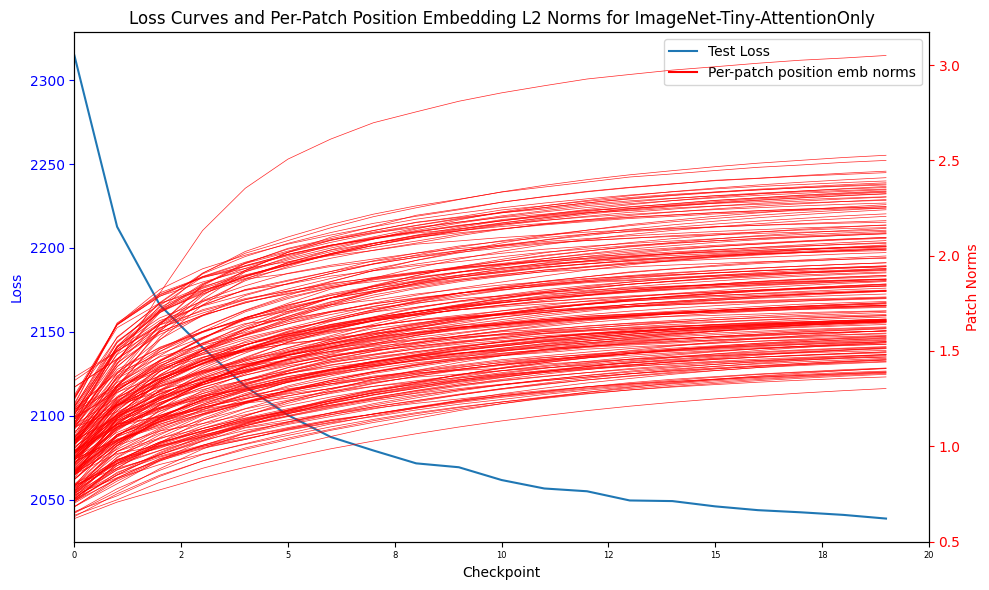

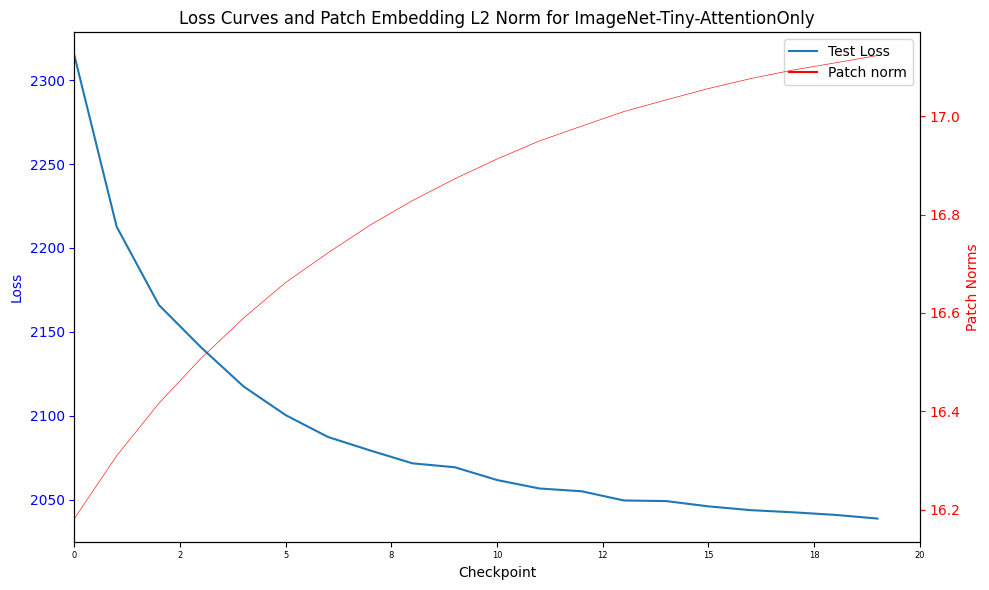

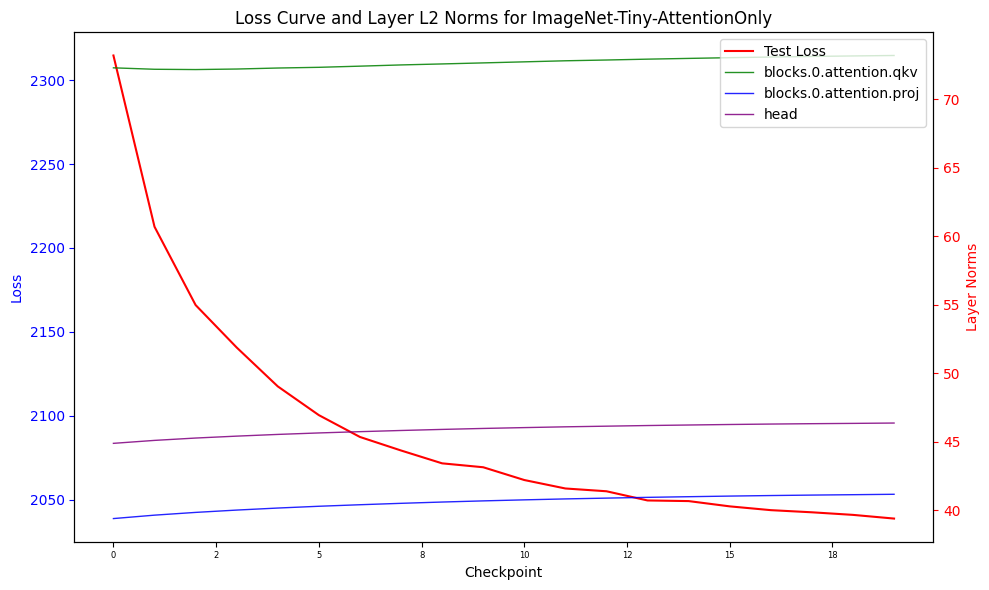

File already exists.


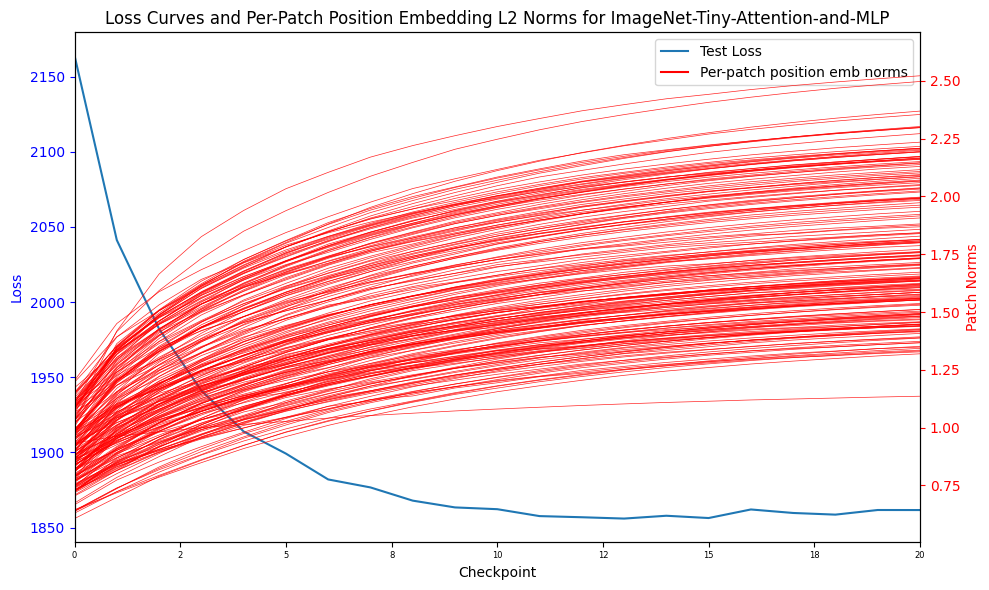

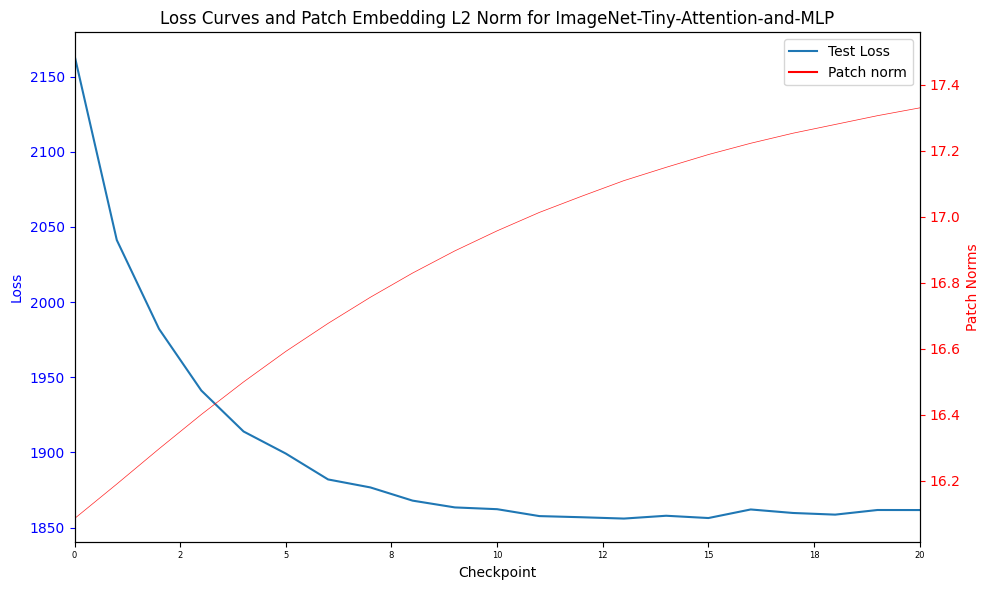

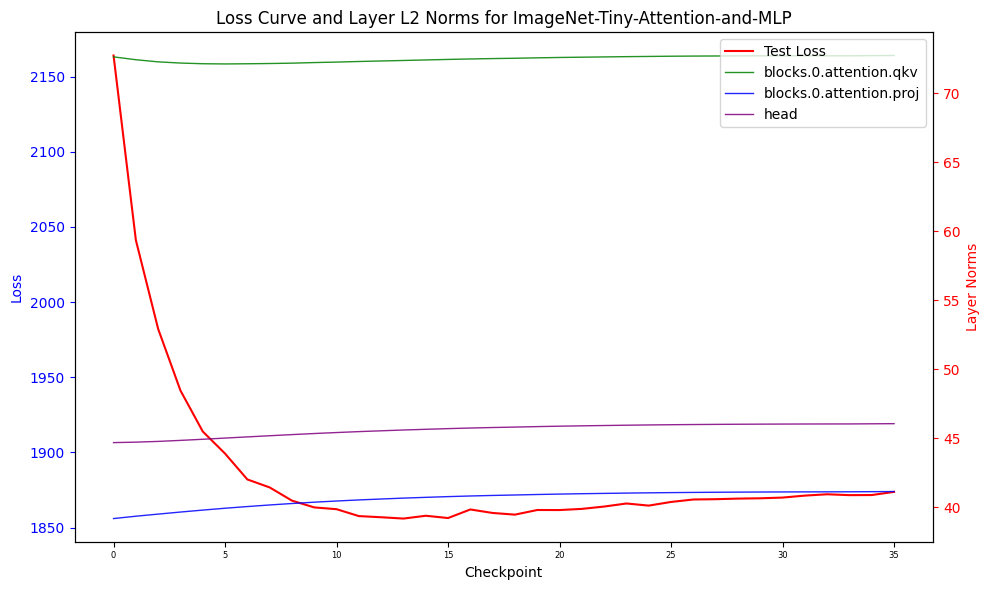

File already exists.


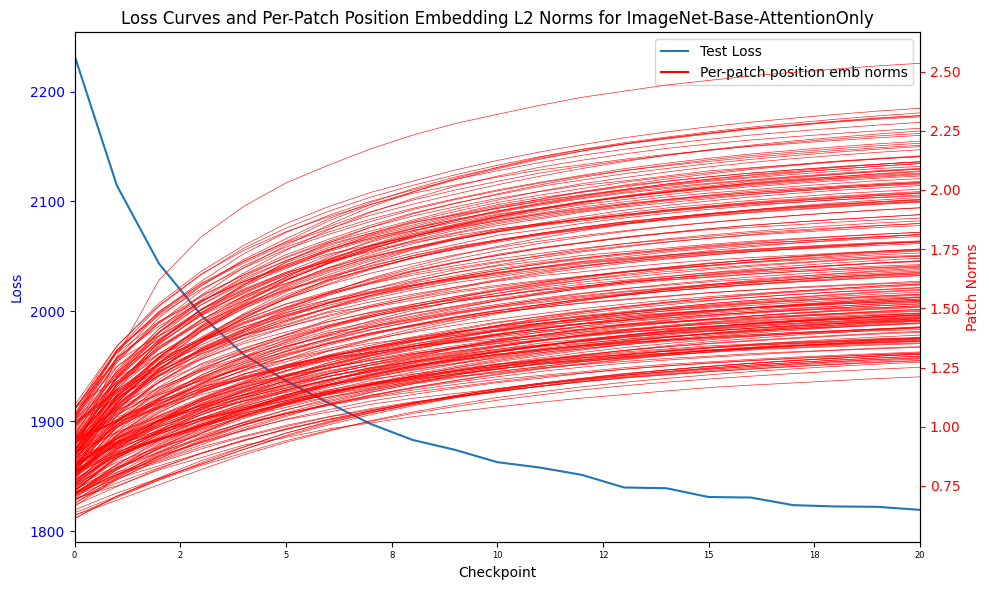

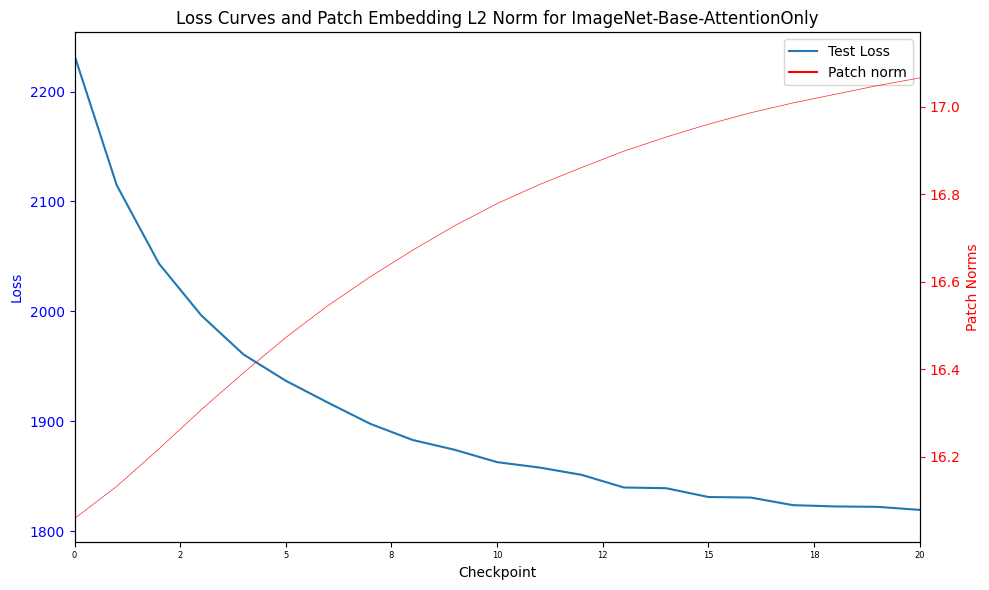

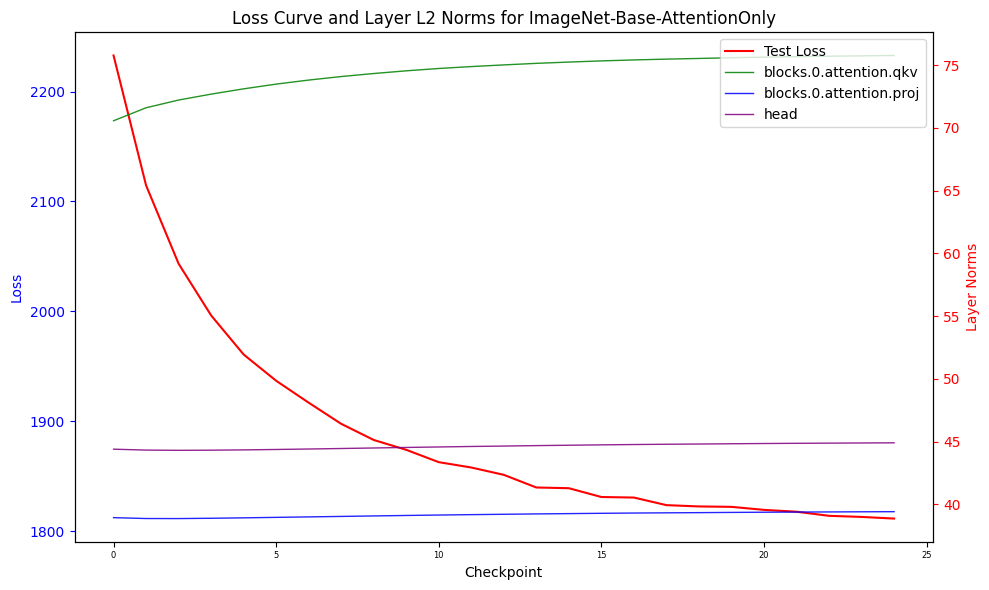

File already exists.


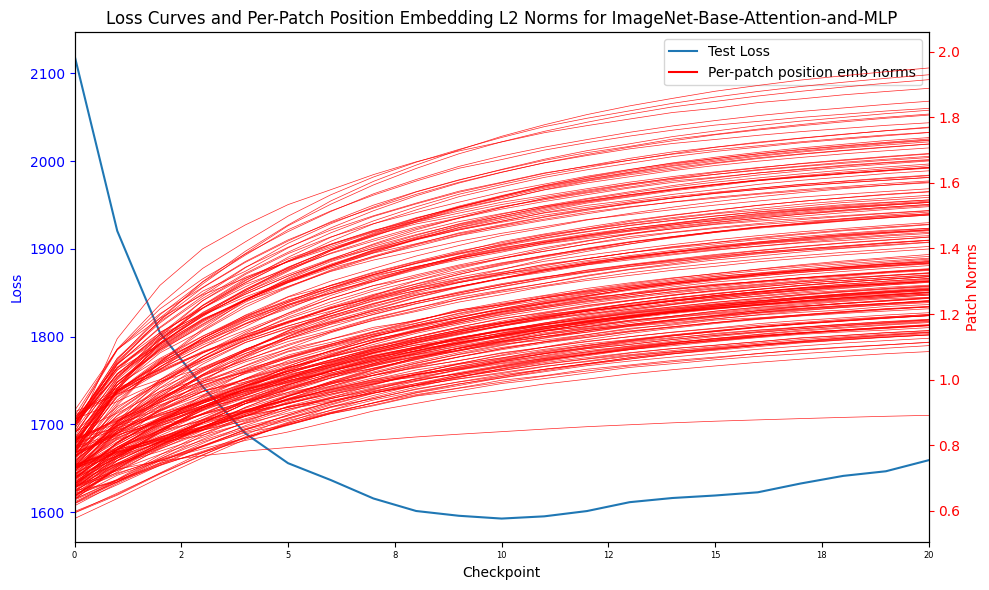

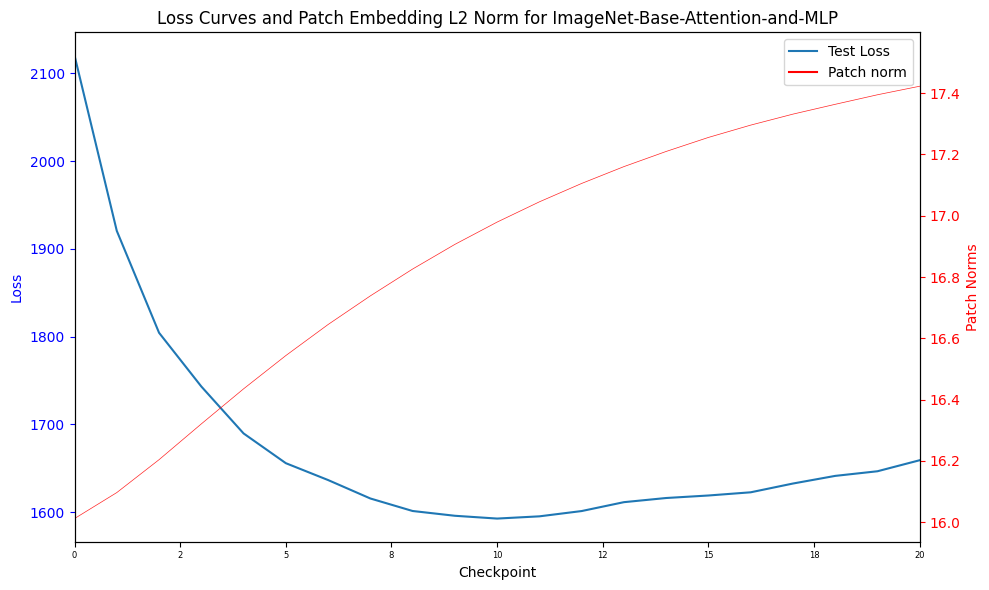

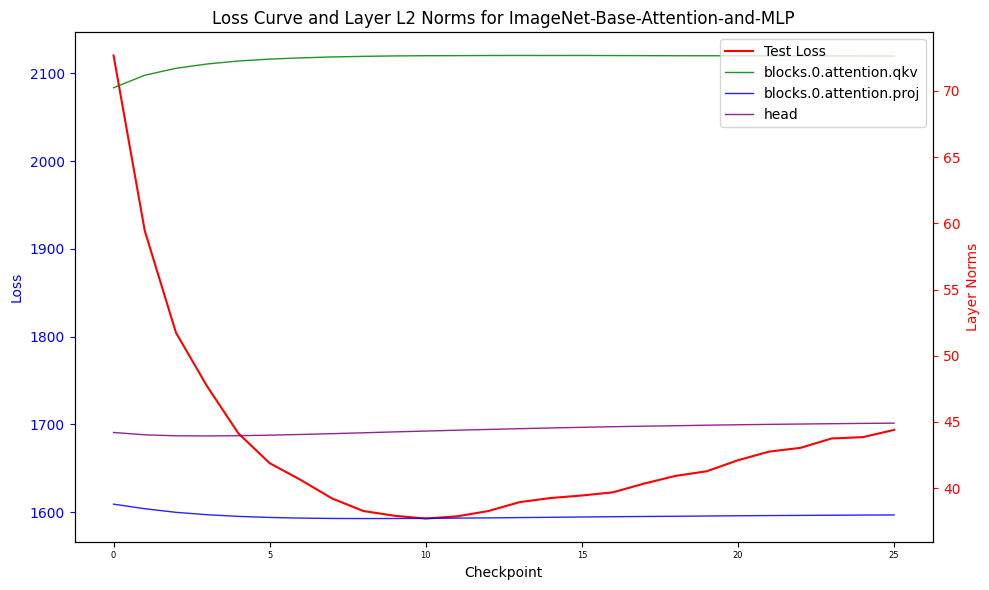

File already exists.


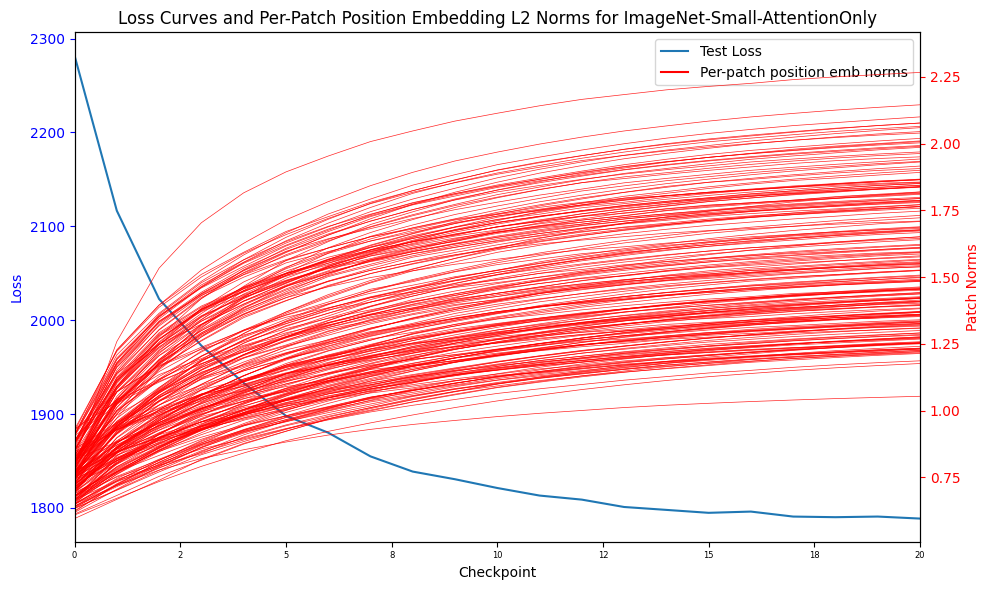

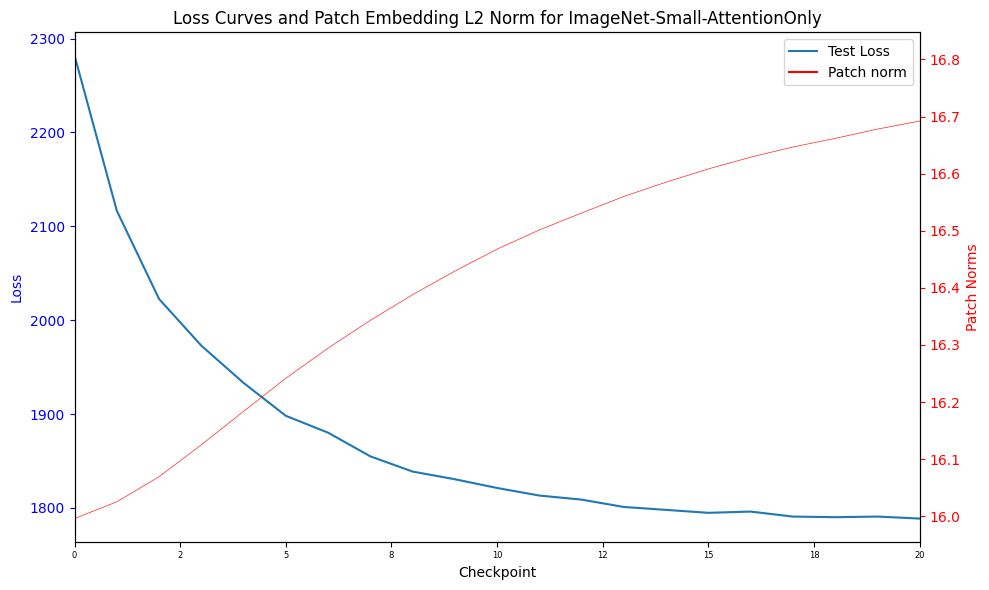

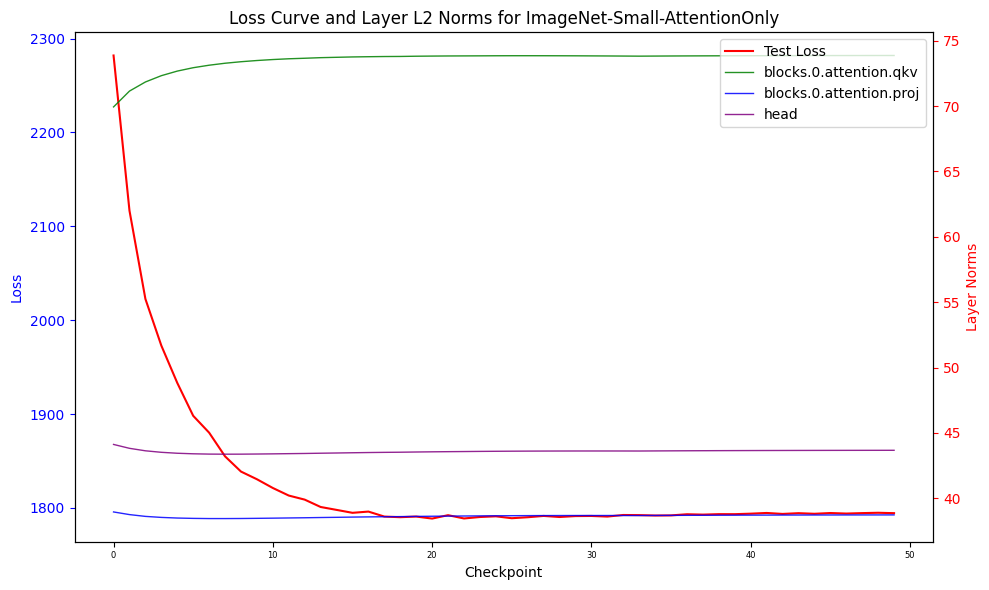

File already exists.


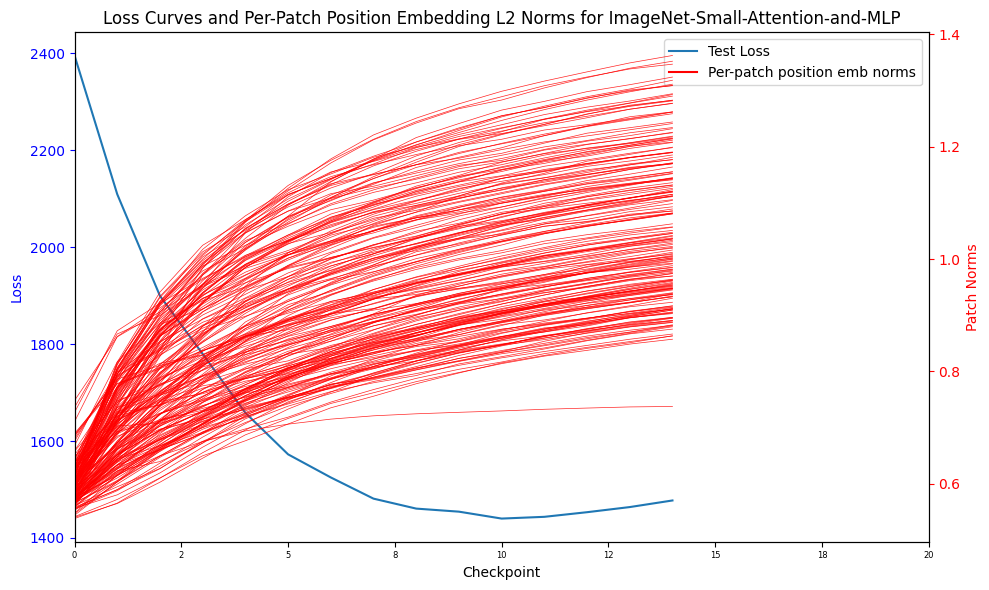

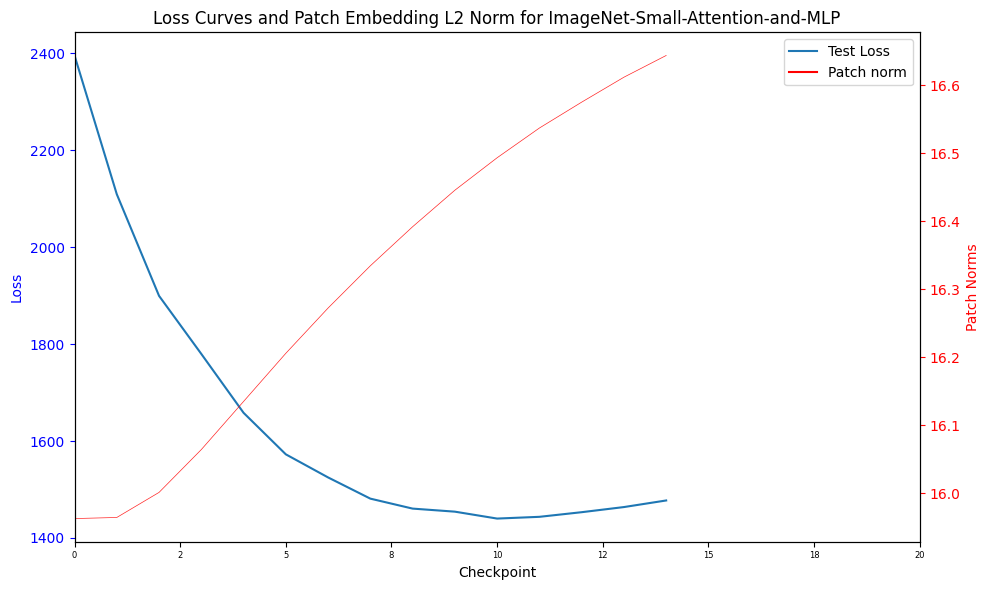

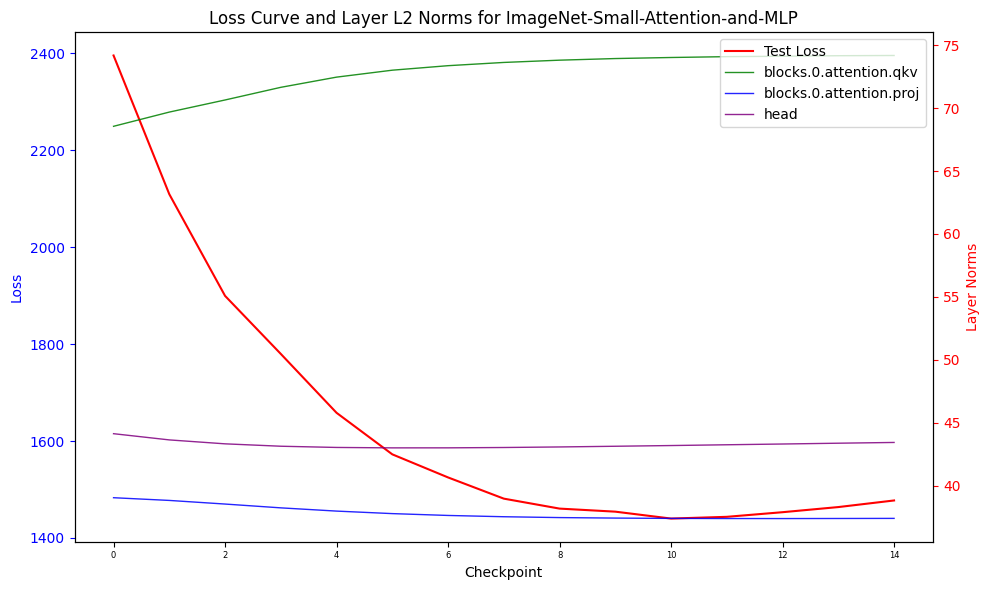

File already exists.


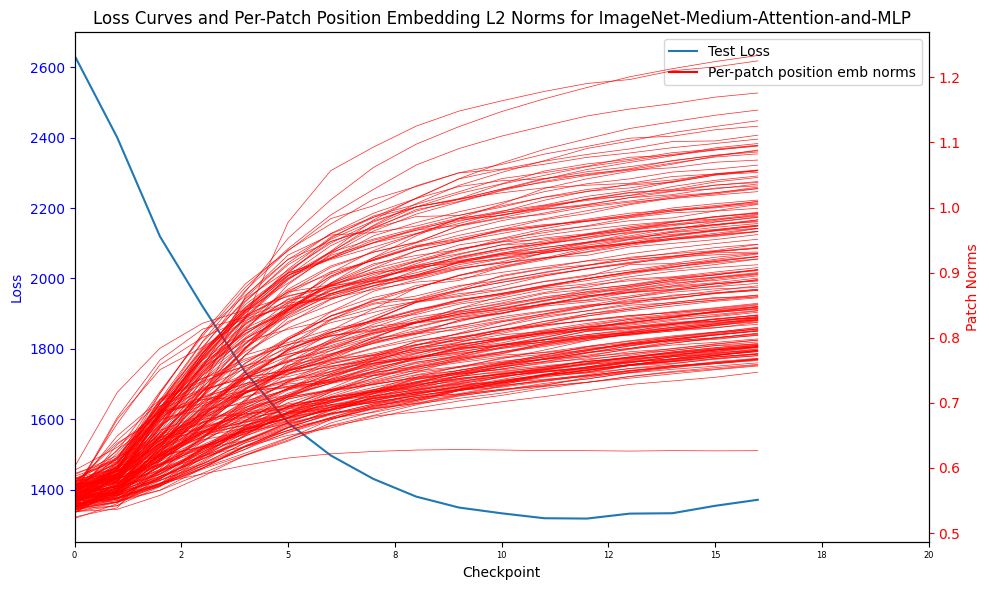

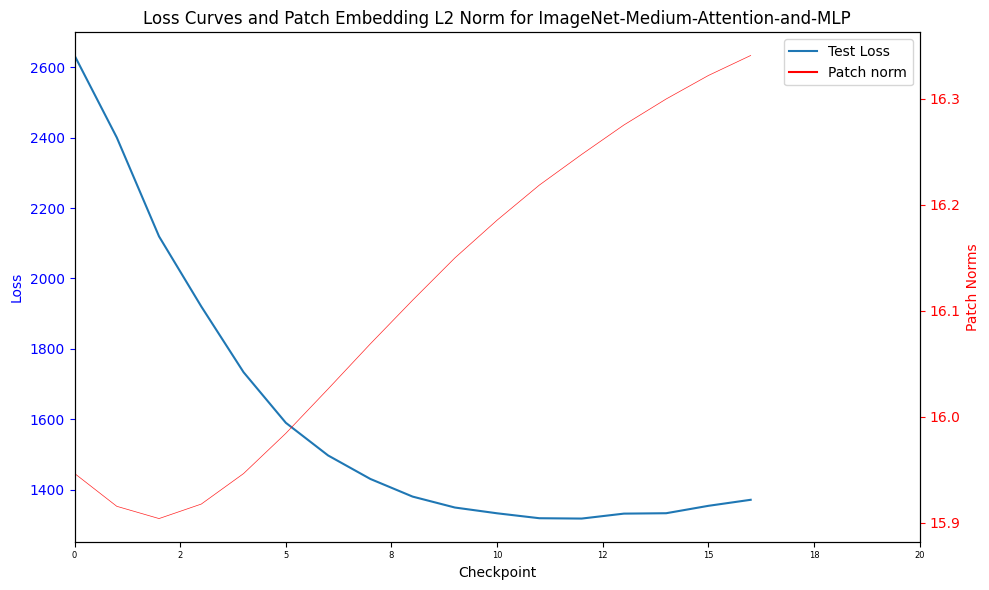

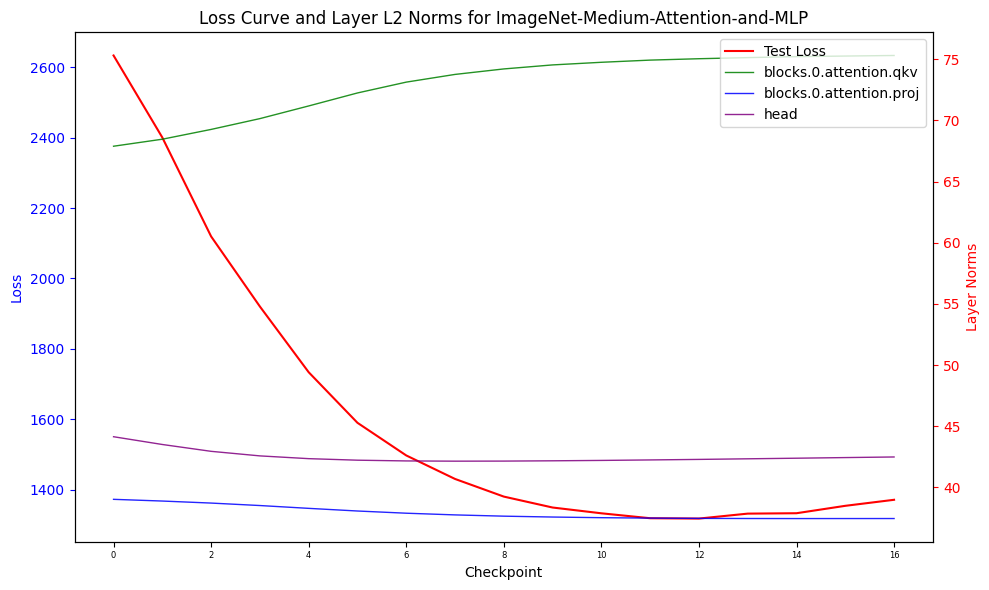

File already exists.


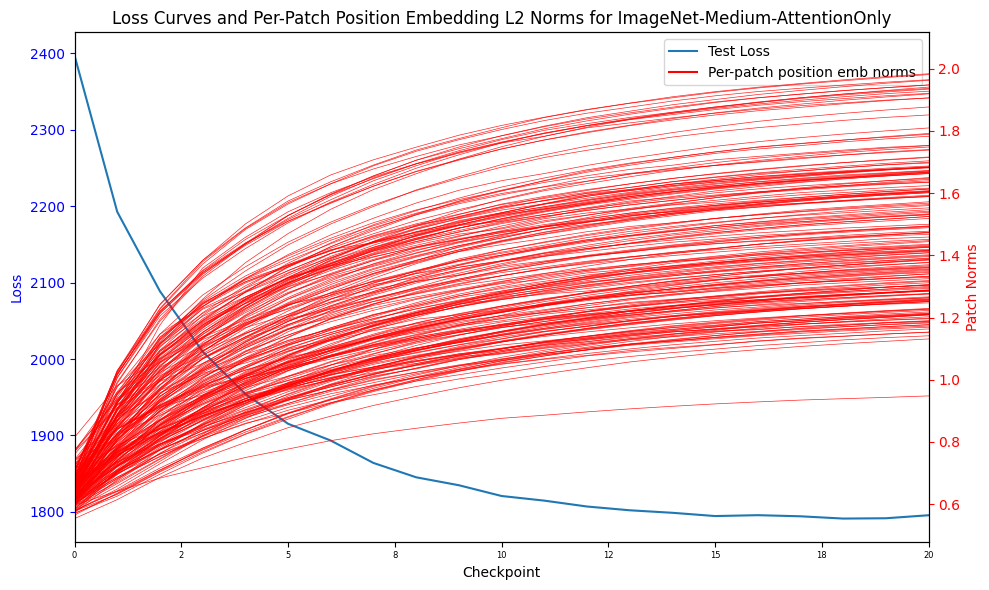

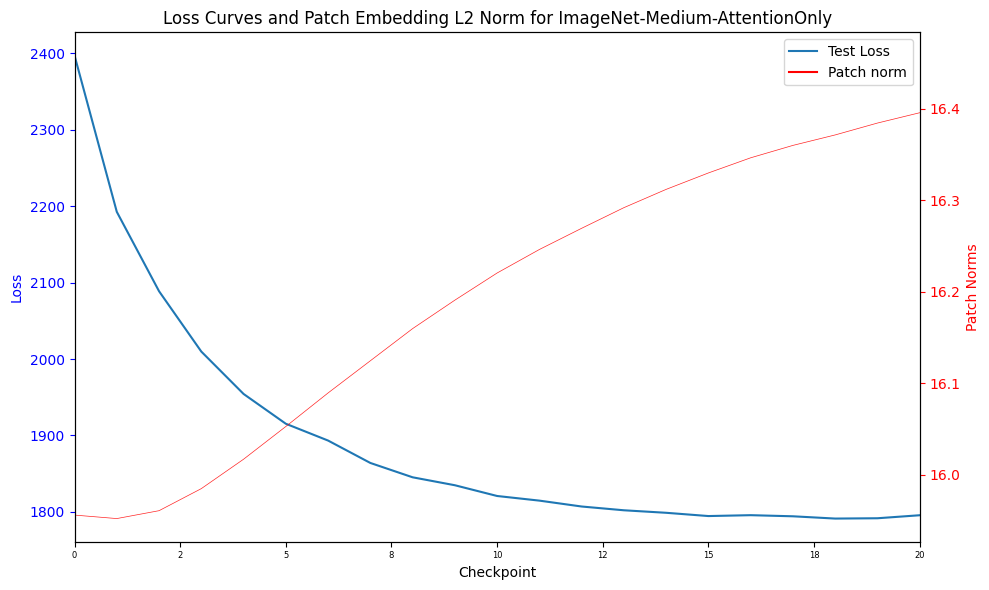

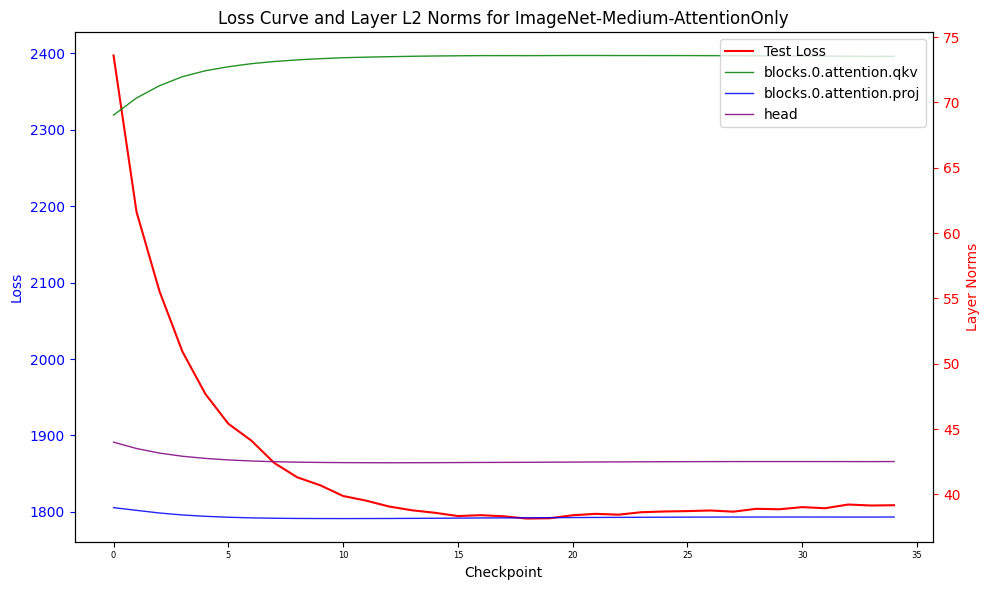

In [38]:
import numpy as np 

def plot_all_weights_for_model(repo_name):

    full_repo_id = f'IamYash/{repo_name}'
    
    _, num_checkpoints = get_checkpoint_info(full_repo_id)

    patch_num = 197
    pos_norms = np.zeros((patch_num, num_checkpoints))
    patch_norms = []

    all_other_norms = []

    for c in range(num_checkpoints):
        model = load_huggingface_model(c, full_repo_id,  TOTAL_DICTIONARY[repo_name]['transformer_config'])

        norms = get_position_embedding_norms(model).numpy()
        pos_norms[:, c] = norms
        
        patch_norms.append(get_patch_embedding_norms(model).detach().numpy())

        other_norms, std_norms = other_layer_norms(model)
        all_other_norms.append(other_norms)

    # create loss
    create_loss(repo_name, TOTAL_DICTIONARY[repo_name]['run_id'])

    plot_pos(f'loss_curves/{repo_name}.csv', repo_name, pos_norms)
    plot_patch(f'loss_curves/{repo_name}.csv', repo_name, patch_norms)
    plot_all_other(f'loss_curves/{repo_name}.csv', repo_name, all_other_norms)
        


for k in TOTAL_DICTIONARY.keys():
    plot_all_weights_for_model(k)



In [ ]:
# layers = ['blocks.0.attention.qkv', 'blocks.0.attention.proj', 'head']
# norms = {layer: [] for layer in layers}

# for checkpoint in all_other_norms:
#     for layer in layers:
#         norms[layer].append(checkpoint[layer].cpu().item())  # Convert tensor to a regular number


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data loading and processing code
# ...

# Custom colors for each layer
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray']
color_iter = iter(colors)

# Creating figure and axis objects with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the loss curve
ax1.plot(test_df["Step"], test_df["silver-jazz-185 - test_loss"], label="Test Loss", color=next(color_iter))
ax1.plot(train_df["Step"], train_df["silver-jazz-185 - train_loss"], label="Train Loss", color = next(color_iter))

ax1.set_xlabel('Checkpoint')
ax1.tick_params(axis='x', labelsize=6)
ax1.set_ylabel('Loss', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xticks(checkpoint_numbers)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))

# Creating a second y-axis for layer norms
ax2 = ax1.twinx()

# Plotting each layer with a different color
for layer, values in norms.items():
    ax2.plot(checkpoint_numbers, values, label=layer, linewidth=1, alpha=0.86, color=next(color_iter))

ax2.set_ylabel('Layer Norms', color='r')
ax2.tick_params('y', colors='r')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Loss Curves and Per-Patch Position Embedding L2 Norms")
fig.tight_layout()
plt.show()
